In [1]:
import nbimporter
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch import nn
from torch.optim import SGD
from sklearn.metrics import accuracy_score
from os.path import join
import torch
import numpy as np
from PIL import Image
from os import path

import python_file.dataclass as StreetSign
import python_file.function as Function
import python_file.network as Network

import matplotlib.pyplot as plt

import dataset_class as prova

np.random.seed(1328)
torch.random.manual_seed(1328);

In [2]:
#resize normale
tran = transforms.Compose([StreetSign.Rescale(32),StreetSign.RandomCrop(32),StreetSign.ToTensor()])

In [3]:
datatrain = StreetSign.StreetSignDataset('DITS-full\DITS-full\DITS-detection\class\classes.csv','DITS-full\DITS-full\DITS-detection\class\image',tran)
datatest = StreetSign.StreetSignTest('DITS-full\DITS-full\DITS-detection\detection_test\day\prova.txt','DITS-full\DITS-full\DITS-detection\detection_test\day',tran)

In [4]:
datatrain_loader = DataLoader(datatrain, batch_size=1024, shuffle=True)
datatest_loader = DataLoader(datatest, batch_size=1024, shuffle=True)

In [5]:
#number of epoch
epoche = 100

In [6]:
minialexnetV2_datatrain = Network.MiniAlexNetV2()

minialexnetV2_datatrain = Function.train_classifier(minialexnetV2_datatrain, datatrain_loader, datatest_loader, \
                                                    'minialexnetV2_dataset', epochs = epoche)

minialexnetV2_data_test_predictions, data_labels_test = Function.test_classifier(minialexnetV2_datatrain,
                                                                               datatest_loader)
print("Accuracy MiniAlexNetV2 su StreetSign: %0.2f" % \
      accuracy_score(data_labels_test,minialexnetV2_data_test_predictions))

Accuracy MiniAlexNetV2 su StreetSign: 0.89


In [7]:
def rec_curve(predictions, gt):
    assert predictions.shape == gt.shape
    # calcoliamo tutti gli errori mediante MAE
    errors = np.abs(np.array((predictions-gt)))
    
    # prendiamo i valori unici degli errori e ordiniamoli
    tolerances = sorted(np.unique(errors))
    correct= [] #lista delle "accuracy" relative a ogni soglia
    
    for t in tolerances:
        correct.append((errors<=t).mean()) # frazione di elementi "correttamente" regressi
    AUC = np.trapz(correct, tolerances) #area sotto la curva calcolata col metodo dei trapezi
    tot_area = np.max(tolerances)*1 # area totale
    AOC = tot_area - AUC
    # restituiamo le soglie, la frazione di campioni correttamente regressi e l'area sopra la curva
    return tolerances, correct, AOC

In [8]:
minialexnetV2_data_test_predictions, data_labels_test = Function.test_classifier(minialexnetV2_datatrain,
                                                                               datatest_loader)

minialexnetV2_data_train_predictions, data_labels_train = Function.test_classifier(minialexnetV2_datatrain,
                                                                               datatrain_loader)

[0, 1, 2]
[0.8878787878787879, 0.9666666666666667, 1.0]
0.08939393939393936


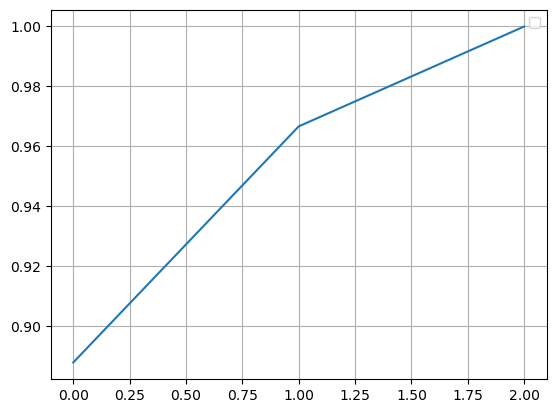

In [9]:
# REC curve:
alexnet_rec_test = rec_curve(minialexnetV2_data_test_predictions, data_labels_test)
alexnet_rec_train = rec_curve(minialexnetV2_data_train_predictions, data_labels_train)
print(alexnet_rec_test[0])
print(alexnet_rec_test[1])
print(alexnet_rec_test[2])
plt.plot(alexnet_rec_test[0], alexnet_rec_test[1])
plt.plot(alexnet_rec_train[0], alexnet_rec_train[1])
plt.legend(['AlexNetTest. AOC: %.2f'%alexnet_rec_test[2]],['AlexNetTrain. AOC: %.2f'%alexnet_rec_train[2]])
plt.grid()
plt.show()